# Splitting and Cross-validation

## Lecture Learning Objectives 

- Explain the concept of generalization.
- Split a dataset into train and test sets using `train_test_split` function.
- Explain the difference between train, validation, test, and "deployment" data.
- Identify the difference between training error, validation error, and test error.
- Explain cross-validation and use `cross_val_score()` and `cross_validate()` to calculate cross-validation error.
- Explain overfitting, underfitting, and the fundamental tradeoff.
- State the golden rule and identify the scenarios when it's violated.

## Five Minute Recap/ Lightning Questions 

- What is an example of machine learning? 
- Which type of machine learning does not have labels?
- What is an example of a Regression problem? 
- In a dataframe, what is an observation? 
- What is the first node of a Decision Tree called?
- Where/who determines the parameter values?
- What library will we be using for machine learning? 

In [1]:
import pandas as pd


voting_df = pd.read_csv('data/cities_USA.csv',index_col=0)
voting_df

,lon,lat,vote
1,-80.162475,25.692104,blue
2,-80.214360,25.944083,blue
3,-80.094133,26.234314,blue
4,-80.248086,26.291902,blue
5,-81.789963,26.348035,blue
...,...,...,...
396,-97.460476,48.225094,red
397,-96.551116,48.591592,blue
398,-166.519855,53.887114,red
399,-163.733617,67.665859,red


In [2]:
from sklearn.tree import DecisionTreeClassifier


# feature table
X = voting_df.drop(columns='vote')
# the target variable
y = voting_df[['vote']]

# initiate model framework with a decision tree of max_depth 2
model = DecisionTreeClassifier(max_depth=2)
# training the model
model.fit(X, y)

# new longitude and latitude coordinates
lon_lat_coords = [[-75, 56]]
# predict on coordinates
prediction = model.predict(lon_lat_coords)

print('With a latitude of', lon_lat_coords[0][1],
      'and a longitude of', lon_lat_coords[0][0], 
      'the model predicted', prediction[0])

With a latitude of 56 and a longitude of -75 the model predicted blue


/home/joel/miniconda3/envs/bait/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### Some lingering questions

1. How do we choose a value of `max_depth` (or other hyperparameters)?
2. Why not just use large `max_depth` for every supervised learning problem and get super high accuracy?
3. Is model performance on the training data a good indication of how it will perform on new data?


We will be answering these questions in this lecture. 

## Generalization

### Visualizing model complexity using decision boundaries

In the last lecture, we saw that we could visualize the splitting of decision trees using these boundaries. 

So let's look back at our cities dataset.

In [3]:
voting_df = pd.read_csv(
    'data/cities_USA.csv',
    index_col=0
).query(
    'lon > -140'  # Remove alaska for easier plotting
)
voting_df

,lon,lat,vote
1,-80.162475,25.692104,blue
2,-80.214360,25.944083,blue
3,-80.094133,26.234314,blue
4,-80.248086,26.291902,blue
5,-81.789963,26.348035,blue
...,...,...,...
393,-101.115061,47.640333,red
394,-119.036728,47.926446,blue
395,-102.142732,47.955970,red
396,-97.460476,48.225094,red


We then create our feature table and our target objects (`X` and `y`) 

In [4]:
X = voting_df.drop(columns=["vote"])
X

,lon,lat
1,-80.162475,25.692104
2,-80.214360,25.944083
3,-80.094133,26.234314
4,-80.248086,26.291902
5,-81.789963,26.348035
...,...,...
393,-101.115061,47.640333
394,-119.036728,47.926446
395,-102.142732,47.955970
396,-97.460476,48.225094


In [5]:
y = voting_df["vote"]
y

1      blue
2      blue
3      blue
4      blue
5      blue
       ... 
393     red
394    blue
395     red
396     red
397    blue
Name: vote, Length: 397, dtype: object

Let's build our model now. 

We're going to build a decision tree classifier and set the `max_depth` hyperparameter to 1 to create a decision stump. 



In [6]:
depth = 1
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X, y)
model.score(X, y)

0.7531486146095718

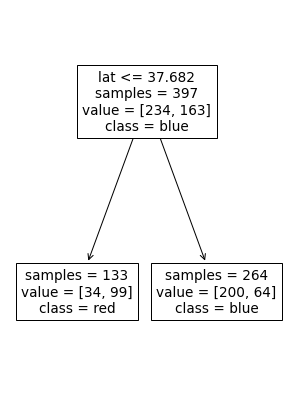

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


plot_tree(
    model,
    feature_names=X.columns,
    class_names=y.unique(),
    impurity=False,
    ax=plt.subplots(figsize=(5, 7))[1]
);

In this decision tree, there is only 1 split.  

In [8]:
model.score(X, y)

0.7531486146095718

When we score it on data that it’s already seen, we get an accuracy of 75%.

Plotting the values, we see the decision boundary separating the 2 regions where lat=37.682.

/home/joel/miniconda3/envs/bait/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


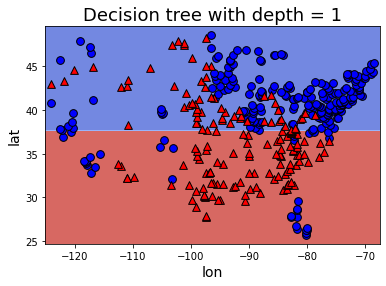

In [9]:
from plot_classifier import plot_classifier


plot_classifier(X, y, model, ticks=True)
plt.xlabel('lon', fontsize=14)
plt.ylabel('lat', fontsize=14)
plt.title("Decision tree with depth = %d" % (depth), fontsize=18);

Ok, now let's see what happens to our decision boundaries when we change our maximum tree depth to 2. 

In [10]:
depth = 2
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X, y)
model.score(X, y)

0.8261964735516373

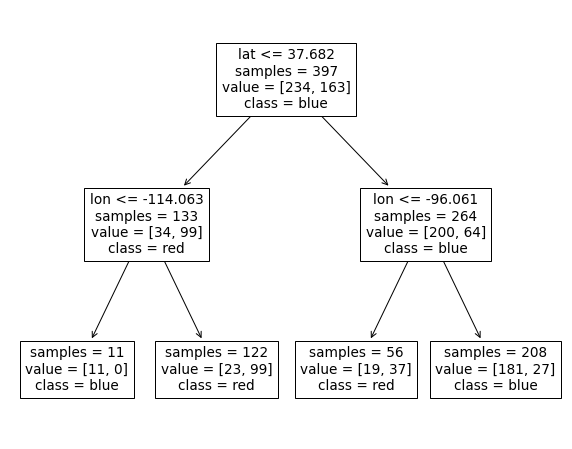

In [11]:
plot_tree(
    model,
    feature_names=X.columns,
    class_names=y.unique(),
    impurity=False,
    ax=plt.subplots(figsize=(10, 8))[1]
);

The decision boundaries are created by asking 3 questions (only possible to ask 2 questions per observation) and we can see 3 splits now. 

Our score here has increased from 75% to 83%.

When we graph it, we can now see 3 boundaries. 2 where `lon` equals -114.063 and -96.061 and another where `lat` equals 37.682.  

/home/joel/miniconda3/envs/bait/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


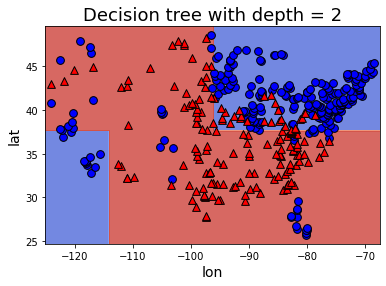

In [12]:
plot_classifier(X, y, model, ticks=True)
plt.xlabel('lon', fontsize=14)
plt.ylabel('lat', fontsize=14)
plt.title("Decision tree with depth = %d" % (depth), fontsize=18);

Now let’s continue on making a new model with a hyperparameter `max_depth` equal to 4. 

In [13]:
depth = 4
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X, y);
model.score(X, y)

0.8967254408060453

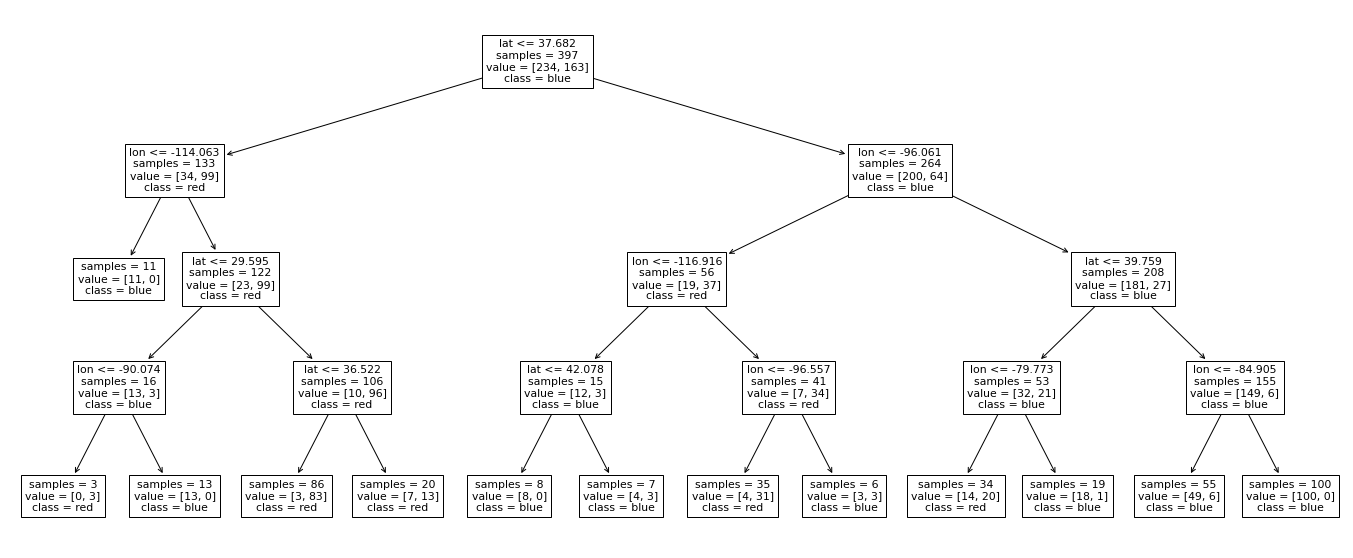

In [14]:
plot_tree(
    model,
    feature_names=X.columns,
    class_names=y.unique(),
    impurity=False,
    ax=plt.subplots(figsize=(24, 10))[1]
);

Our score now has shot up to 90% and we have way more splits now.

We can see our boundaries are getting more complex. 

/home/joel/miniconda3/envs/bait/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


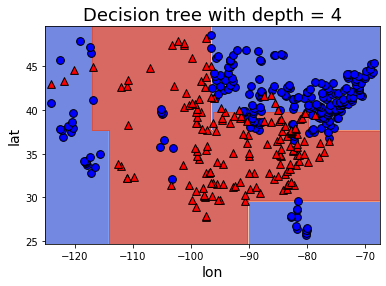

In [15]:
plot_classifier(X, y, model, ticks=True)
plt.xlabel('lon', fontsize=14)
plt.ylabel('lat', fontsize=14)
plt.title('Decision tree with depth = %d' % (depth), fontsize=18);

What happens if we give the model an unlimited `max_depth`?

In [16]:
model = DecisionTreeClassifier()
model.fit(X, y);
model.get_depth()

8

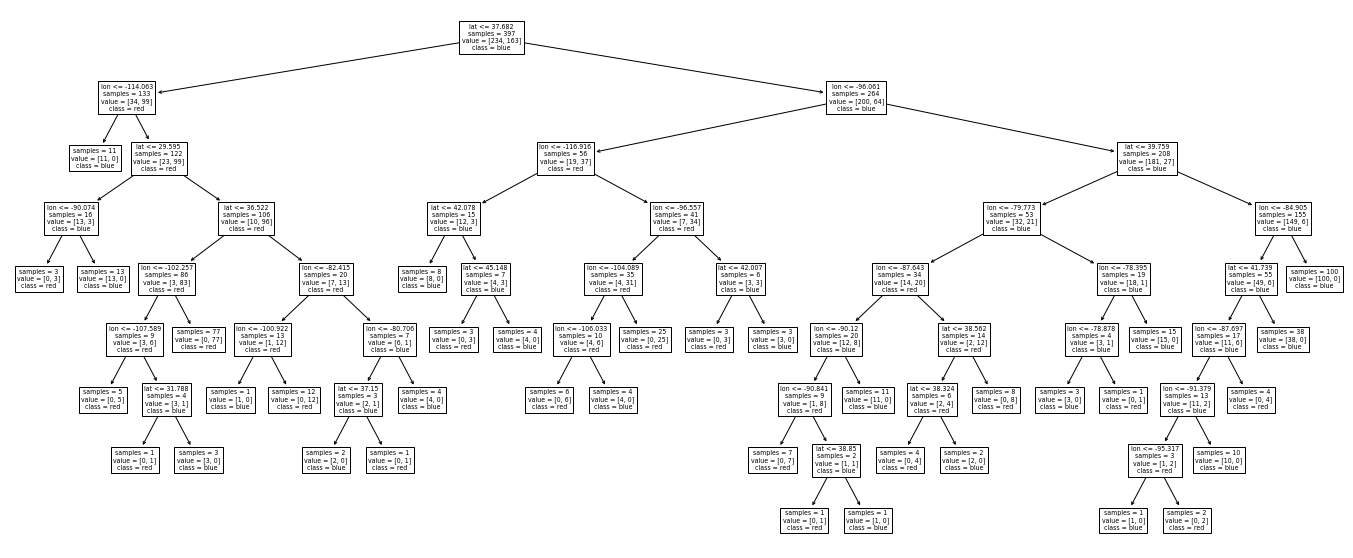

In [17]:
plot_tree(
    model,
    feature_names=X.columns,
    class_names=y.unique(),
    impurity=False,
    ax=plt.subplots(figsize=(24, 10))[1]
);

/home/joel/miniconda3/envs/bait/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


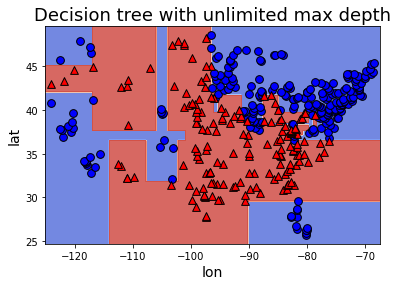

In [18]:
plot_classifier(X, y, model, ticks=True)
plt.xlabel('lon', fontsize=14)
plt.ylabel('lat', fontsize=14)
plt.title('Decision tree with unlimited max depth', fontsize=18);

In [19]:
model.score(X, y)

1.0

Our score is now 100%.
Do you think that's going to be helpful for us to have a model with a perfect score on all the data?

We can see that with this model we are perfectly fitting every observation.
That must be great right?
Not so fast.
In this toy example,
we have evaluated the model on the same data we used to train it,
but how would it perform on a city that did not exist in the training data?
We can use the cities from alaska that we excluded initially to find out:

In [20]:
alaska = pd.read_csv(
    'data/cities_USA.csv',
    index_col=0
).query(
    'lon <= -140'  # Remove alaska for easier plotting
)
alaska

,lon,lat,vote
398,-166.519855,53.887114,red
399,-163.733617,67.665859,red
400,-145.423115,68.077395,red


In [21]:
model.predict(alaska[['lon', 'lat']])

array(['blue', 'blue', 'blue'], dtype=object)

Terrible! The model incorrectly predicted "blue" for all three cities.
This illustrates that a model that is more specific and sensitive to the training data,
might not always generalize well to unseen data,
which is our eventual goal
since we will not have all the data and its true target labels upfront
(then we would not need ML in the first place).
For our decision tree model,
we see that score increases as we increase `max_depth`.
Since we are creating a more complex tree (higher `max_depth`)
we can fit all the peculiarities of our data to eventually get 100% accuracy.

### The Fundamental goal of machine learning

Goal: **to generalize beyond what we see in the training examples**. <br>
We are only given a sample of the data and do not have the full distribution. <br>
Using the training data, we want to come up with a reasonable model that will perform well on some unseen examples. <br>

At the end of the day, we want to deploy models that make reasonable predictions on unseen data


<img src='imgs/generalization-train.png'  width = "30%" alt="404 image" />

### Generalizing to unseen data

<img src="imgs/generalization-predict.png" width = "100%" alt="404 image" />

Would you expect her to be able to correctly identify each image?

The point here is that we want this learning to be able to generalize beyond what it sees here and be able to predict and predict labels for the new examples.

These new examples should be representative of the training data.

### Training score versus Generalization score (or Error)

- Although we can get 100% accuracy on our model, do we trust it? 

What if we used the model we saw that gives 100% accuracy, Would you expect this model to perform equally well on unseen examples? Probably not. 

Given a model in machine learning, people usually talk about two kinds of accuracies (scores):

1. Accuracy on the training data
    
2. **Accuracy on the entire distribution of data**


We are really interested in the score on the entire distribution because at the end of the day we want our model to perform well on unseen examples. 

But the problem is that we do not have access to the distribution and only the limited training data that is given to us. 

So, what do we do? 

## Splitting

We can approximate generalization accuracy by splitting our data!


<img src="imgs/splitted.png"  width = "60%" alt="404 image" />


- Keep a randomly selected portion of our data aside that we call that the testing data. 

- fit (train) a model on the training portion only.
- score (assess) the trained model on this set-aside **Testing** data to get a sense of how well the model would be able to generalize.


###  Simple train and test split


<img src="imgs/train-test-split.png"  width = "100%" alt="404 image" />




- First, the data needs to be shuffled.
- Then, we split the rows of the data into 2 sections -> **train** and **test**. 

- The lock and key icon on the test set symbolizes that we don't want to touch the test data until the very end (more on this soon).


### How do we do this? 

In our trusty Scikit Learn package, we have a function for that! 
- `train_test_split`

Let's try it out using a similar yet slightly different dataset. Here we still have `latitude` and `longitude` coordinates but this time our target variable is if the city with these coordinates lies in Canada or the USA. 

#### First way

In [22]:
cities_df = pd.read_csv('data/canada_usa_cities.csv')  

cities_df

,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA
...,...,...,...
204,-72.7218,45.3990,Canada
205,-66.6458,45.9664,Canada
206,-79.2506,42.9931,Canada
207,-72.9406,45.6275,Canada


In [23]:
X = cities_df.drop(columns=["country"])
X

,longitude,latitude
0,-130.0437,55.9773
1,-134.4197,58.3019
2,-123.0780,48.9854
3,-122.7436,48.9881
4,-122.2691,48.9951
...,...,...
204,-72.7218,45.3990
205,-66.6458,45.9664
206,-79.2506,42.9931
207,-72.9406,45.6275


In [24]:
y = cities_df["country"]
y

0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
204    Canada
205    Canada
206    Canada
207    Canada
208    Canada
Name: country, Length: 209, dtype: object

In [25]:
from sklearn.model_selection import train_test_split


# Split the dataset into 80% train and 20% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [26]:
X_train

,longitude,latitude
160,-76.4813,44.2307
127,-81.2496,42.9837
169,-66.0580,45.2788
188,-73.2533,45.3057
187,-67.9245,47.1652
...,...,...
17,-76.3305,44.1255
98,-74.7287,45.0184
66,-121.4944,38.5816
126,-79.5656,43.6436


In [27]:
X_test

,longitude,latitude
172,-64.8001,46.0980
175,-82.4066,42.9746
181,-111.3885,56.7292
132,-78.8630,43.9177
189,-112.8516,49.6943
195,-122.7454,53.9129
198,-72.5019,45.8864
170,-79.0906,43.8358
95,-79.0546,43.1642
31,-74.0060,40.7127


In [28]:
y_train

160    Canada
127    Canada
169    Canada
188    Canada
187    Canada
        ...  
17        USA
98     Canada
66        USA
126    Canada
109    Canada
Name: country, Length: 167, dtype: object

In [29]:
y_test

172    Canada
175    Canada
181    Canada
132    Canada
189    Canada
195    Canada
198    Canada
170    Canada
95     Canada
31        USA
42        USA
179    Canada
191    Canada
120    Canada
19        USA
72        USA
20        USA
52        USA
147    Canada
166    Canada
119    Canada
200    Canada
4         USA
108    Canada
157    Canada
21        USA
91     Canada
158    Canada
137    Canada
194    Canada
197    Canada
53        USA
180    Canada
162    Canada
184    Canada
161    Canada
10        USA
71        USA
80        USA
26        USA
11        USA
173    Canada
Name: country, dtype: object

In [30]:
# Print shapes of the training and testing data (you can ignore the code here)
pd.DataFrame({
    "Variable name": ["X", "y", "X_train", "y_train", "X_test", "y_test"],
    "Shape": [X.shape, y.shape,
              X_train.shape, y_train.shape,
              X_test.shape, y_test.shape]
})

,Variable name,Shape
0,X,"(209, 2)"
1,y,"(209,)"
2,X_train,"(167, 2)"
3,y_train,"(167,)"
4,X_test,"(42, 2)"
5,y_test,"(42,)"


#### Second way

Instead of splitting our `X` and `y` objects. We can split the whole dataset first into train and test splits. 

The earlier to split the data the better,
so this alternative is preferred in general.

In [31]:
cities_df

,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA
...,...,...,...
204,-72.7218,45.3990,Canada
205,-66.6458,45.9664,Canada
206,-79.2506,42.9931,Canada
207,-72.9406,45.6275,Canada


In [32]:
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)

X_train = train_df.drop(columns=["country"])
y_train = train_df["country"]

X_test = test_df.drop(columns=["country"])
y_test = test_df["country"]

train_df

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada
...,...,...,...
17,-76.3305,44.1255,USA
98,-74.7287,45.0184,Canada
66,-121.4944,38.5816,USA
126,-79.5656,43.6436,Canada


Sometimes we may want to keep the target in the train split for EDA or for visualization.

In [33]:
import altair as alt


chart_votes = alt.Chart(train_df).mark_circle(size=20, opacity=0.6).encode(
    alt.X('longitude:Q', scale=alt.Scale(domain=[-140, -50])),
    alt.Y('latitude:Q', scale=alt.Scale(domain=[25, 60])),
    alt.Color('country:N', scale=alt.Scale(domain=['Canada', 'USA'],
                                           range=['red', 'blue'])))
chart_votes

alt.Chart(...)

### Applications with Splitting

Let's fit the model and look at the decision tree.

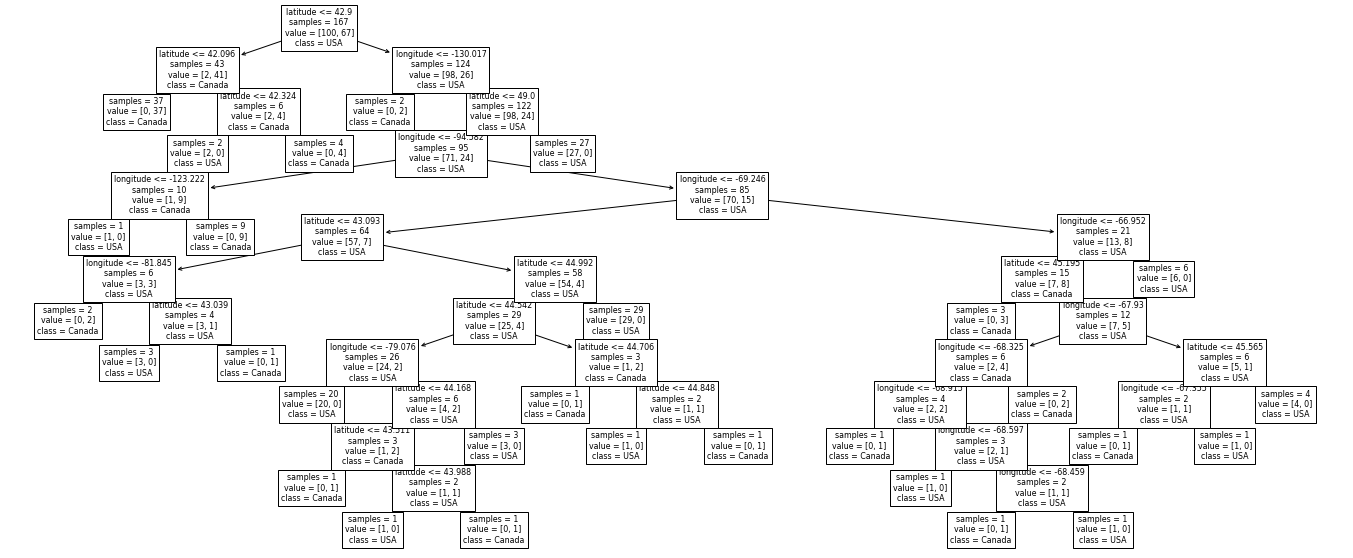

In [34]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

plot_tree(
    model,
    feature_names=X.columns,
    class_names=y.unique(),
    impurity=False,
    ax=plt.subplots(figsize=(24, 10))[1]
);

Let's see how on model scores on the training data and the test data.

In [35]:
print("Train score: " + str(round(model.score(X_train, y_train), 2)))
print("Test score: " + str(round(model.score(X_test, y_test), 2)))

Train score: 1.0
Test score: 0.76


For this tree, the training score is 1.0 and the test score is only 0.74.  

The model does not perform quite as well on data that it has not seen. 

Let's look at the training and testing data with the decision boundaries made by the model. 

/home/joel/miniconda3/envs/bait/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/joel/miniconda3/envs/bait/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


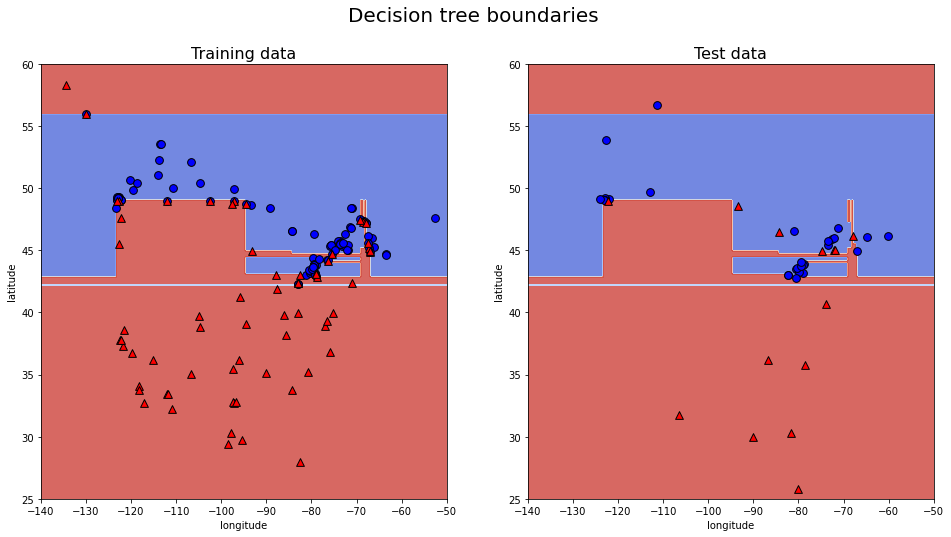

In [36]:
model.fit(X_train, y_train);

plt.figure(figsize=(16, 8))
plt.suptitle('Decision tree boundaries', fontsize=20)
plt.subplot(1, 2, 1);
plt.title("Training data", fontsize=16);
plot_classifier(X_train, y_train, model, ticks=True, ax=plt.gca(), lims=(-140,-50,25,60))
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.subplot(1, 2, 2);
plt.title("Test data", fontsize=16);
plot_classifier(X_test, y_test, model, ticks=True, ax=plt.gca(), lims=(-140,-50,25,60))
plt.xlabel("longitude")
plt.ylabel("latitude");

On the left and the right, we have the same boundaries But different data being shown.

The model is getting 100 percent accuracy on the training and for that to happen, the model ends up being extremely specific.

The model got over complicated on the training data and this doesn’t generalize to the test data well.

In the plot on the right, we can see some red triangles in the blue area. That is the model making mistakes which explains the 71% accuracy.

### Parameters in `.train_test_split()`

- `test_size` - test split size (0-1)
- `train_size` - train split size (0-1) (only need to specify one if these
- `random_state` - randomizes the split

In [37]:
train_df, test_df = train_test_split(cities_df, test_size = 0.2, random_state = 123)

In [38]:
train_df, test_df = train_test_split(cities_df, train_size = 0.8, random_state = 123)

In [39]:
train_df, test_df = train_test_split(cities_df, test_size = 0.2, train_size = 0.8, random_state = 123)

There is no hard and fast rule on the split sizes should we use. Some common splits are 90/10, 80/20, 70/30 (training/test).

In the above example, we used an 80/20 split.

But there is a trade-off:
- More training -> More information for our model. 
- More test -> Better assessment of our model.

Now let's look at the random_state argument:

The random_state argument controls this shuffling and without this argument set, each time we split our data, it will be split in a different way.

In [40]:
train_df, test_df = train_test_split(cities_df, test_size = 0.2)
train_df

,longitude,latitude,country
155,-80.3123,43.3601,Canada
168,-79.0247,43.8504,Canada
180,-73.4528,45.7326,Canada
74,-75.9774,36.8530,USA
197,-80.4538,42.7972,Canada
...,...,...,...
164,-89.2598,48.4064,Canada
32,-118.2428,34.0537,USA
82,-123.0833,49.0167,Canada
91,-82.4066,42.9746,Canada


We set this to add a component of reproducibility to our code and if we set it with a `random_state` when we run our code again it will produce the same result. 

In [41]:
train_df_rs5, test_df_rs5 = train_test_split(cities_df, test_size = 0.2, random_state = 5)
train_df_rs5

,longitude,latitude,country
39,-96.7969,32.7763,USA
55,-97.5171,35.4730,USA
40,-121.8906,37.3362,USA
54,-83.0466,42.3316,USA
48,-122.3301,47.6038,USA
...,...,...,...
144,-104.6173,50.4488,Canada
118,-79.7599,43.6858,Canada
189,-112.8516,49.6943,Canada
206,-79.2506,42.9931,Canada


In [42]:
train_df_rs7, test_df_rs7 = train_test_split(cities_df, test_size = 0.2, random_state = 7)
train_df_rs7

,longitude,latitude,country
128,-118.7148,50.4165,Canada
195,-122.7454,53.9129,Canada
99,-72.0968,45.0072,Canada
97,-75.5192,44.7184,Canada
14,-78.8784,42.8867,USA
...,...,...,...
151,-71.8890,45.4033,Canada
67,-84.3902,33.7491,USA
25,-67.9353,47.1575,USA
196,-110.6790,50.0430,Canada


## Validation data for hyperparameter optimization

Remember hyperparameters?     
What dataset do we use if we want to find which hyperparameters produce the best generalized model (also called **hyperparameter optimization**)?      
    
It's a good idea to have separate data for tuning the hyperparameters of a model that is not the test set.

Enter, the ***validation*** set. 

So we actually want to split our dataset into 3 splits: train, validation, and test.

<img src='imgs/train-valid-test-split.png' width="100%" />


***Note: There isn't a good consensus on the terminology of what is validation and what is test data.***

We use: 
- **training data**: The data used when fitting to find the best model parameters.

- **validation data**: Data where we have access to the target values, but unlike the training data, we only use this for hyperparameter tuning and model assessment; we don't pass these into `fit`.  This evaluation is still biased as skill on the validation dataset is incorporated into the model hyperparameter configuration.

- **test data** (also called holdout data): Data where we have access to the target values, but in this case, unlike training and validation data, we neither use it in training nor hyperparameter optimization and only use it **once** to evaluate the performance of the best performing model on the validation set. We lock it in a "vault" until we're ready to evaluate and it gives a more unbiased performance score than the validation score since the model configuration has not been tweaked to perform well on the test data in any way.

## "Deployment" data

What's the point of making models? 
 > We want to predict something which we do not know the answer to, so we do not have the target values and we only have the features.

After we build and finalize a model, we deploy it, and then the model is used with data in the wild.

We will use **deployment data** to refer to data, where we do not have access to the target values.

Deployment score is the thing we really care about; it is the performance of the final model on the data in production.

We use validation and test scores as proxies for the deployment score, and we hope they are similar.

So, if our model does well on the validation and test data, we hope it will do well on deployment data.

## Let's Practice 

1\. When is the most optimal time to split our data?     
2\. Why do we split our data?    
3\. Fill in the table below:    

| datasets   | `.fit()` | `.score()` | `.predict()` |
|------------|:--------:|:----------:|:------------:|
| Train      |    ✔️     |         |             |
| Validation |          |          |            |
| Test       |          |       |          |
| Deployment |          |            |            |


```{admonition} Solutions!
:class: dropdown

1. Before we visualize/explore it.

2. To help us assess how well our model generalizes.

3. Fill in the table below:

| datasets   | `.fit()` | `.score()` | `.predict()` |
|------------|:--------:|:----------:|:------------:|
| Train      |    ✔️    |   ✔️      |   ✔️         |
| Validation |          |   ✔️       |     ✔️      |
| Test       |          |    Once    |   Once       |
| Deployment |          |            |      ✔️      |

```

## Cross-validation


<img src='imgs/train-valid-test-split.png' width="100%" />

Problems with having a single train-validation split:

- Only using a portion of your full data set for training/validation (data is our most precious resource!!!)
- If your dataset is small you might end up with a tiny training/validation set
- Might be unlucky with your splits such that they don't well represent your data (shuffling data, as is done in `train_test_split()`, is not immune to being unlucky!)

There must be a better way! 

<img src="https://media.giphy.com/media/i4gLlAUz2IVIk/giphy.gif"  width = "50%" alt="404 image" />

There is! The answer to our problem is called.....

**Cross-validation** (CV) or **𝑘-fold cross-validation**.
In cross-validation,
we perform several training-validation splits and train and evaluate our model across all of them
to find the hyperparameters that performs the best on the data in general.

<img src='imgs/cross-validation.png' width="100%">

- We still have the test set here at the bottom locked away that we will not touch until the end.
- But, we split the training data into $k$ folds ($k>2$, often $k=10$). In the graphic above $k=4$.
- Each "fold" gets a turn at being the validation set.
- Each round will produce a score so after 𝑘-fold cross-validation, it will produce 𝑘 scores. We usually average over the 𝑘 results.
- Note that cross-validation doesn't shuffle the data; it's done in `train_test_split`.
- We can get now a more “robust” score on unseen data since we can see the variation in the scores across folds.  


***Question: What's the disadvantage then? Why not use larger values for $k$?***

> ....


Note that for the same reason as we perform CV with the validation dataset,
we might also perform it with the test data set.
This is referred to as nested CV,
as it includes one outer CV loop for splitting the test data from the validation + training data,
and one inner CV loop for splitting the validation data from the training data
This can be a good idea in practice,
especially if your sample dataset is small,
but it is not as commonly used
as CV for only the validation-training split.

## Cross-validation using `sklearn`

There are 2 ways we can do cross-validation with `sklearn`:
- `.cross_val_score()`
- `.cross_validate()`

Before doing cross-validation we still need to split our data into our training set and our test set and separate the features from the targets. 
So using our `X` and `y` from our Canadian/United States cities data we split it into train/test splits. 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)

### `cross_val_score`


In [44]:
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier(max_depth=4)
cv_score = cross_val_score(model, X_train, y_train, cv=5)
cv_score

array([0.76470588, 0.82352941, 0.78787879, 0.78787879, 0.84848485])

Once, we've imported `cross_val_score` we can make our model and call our model, the feature object and target object as arguments. 

- `cv` determines the cross-validation splitting strategy or how many "folds" there are.

- For each fold, the model is fitted on the training portion and scores on the validation portion.

- The output of `cross_val_score()` is the validation score for each fold. 

In [45]:
cv_score.mean()

0.8024955436720143

In [46]:
cv_score = cross_val_score(model, X_train, y_train, cv=10)
cv_score

array([0.76470588, 0.82352941, 0.70588235, 0.94117647, 0.82352941,
       0.82352941, 0.70588235, 0.9375    , 0.9375    , 0.9375    ])

In [47]:
cv_score.mean()

0.8400735294117647

### `cross_validate`

- Similar to `cross_val_score` but more informative.
- Lets us access training ***and*** validation scores using the parameter `return_train_score`.
- Note: in the dictionary output `test_score` and `test_time` refers to *validation score* and *validation time*

In [48]:
from sklearn.model_selection import cross_validate

In [49]:
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
scores

{'fit_time': array([0.00133681, 0.00104618, 0.00105214, 0.00143766, 0.00189137,
        0.00124383, 0.00106549, 0.00102043, 0.00118423, 0.0009551 ]),
 'score_time': array([0.00084805, 0.00073051, 0.00071216, 0.00147891, 0.00136113,
        0.00078082, 0.00071478, 0.00063181, 0.00072169, 0.00071764]),
 'test_score': array([0.76470588, 0.82352941, 0.70588235, 0.94117647, 0.82352941,
        0.82352941, 0.70588235, 0.9375    , 0.9375    , 0.9375    ]),
 'train_score': array([0.91333333, 0.90666667, 0.90666667, 0.9       , 0.90666667,
        0.91333333, 0.92      , 0.90066225, 0.90066225, 0.90066225])}

We can wrap this in a dataframe for easier reading.

In [50]:
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001337,0.000848,0.764706,0.913333
1,0.001046,0.000731,0.823529,0.906667
2,0.001052,0.000712,0.705882,0.906667
3,0.001438,0.001479,0.941176,0.900000
4,0.001891,0.001361,0.823529,0.906667
5,0.001244,0.000781,0.823529,0.913333
6,0.001065,0.000715,0.705882,0.920000
7,0.001020,0.000632,0.937500,0.900662
8,0.001184,0.000722,0.937500,0.900662
9,0.000955,0.000718,0.937500,0.900662


In [51]:
scores_df = pd.DataFrame(cross_validate(model, X_train, y_train, cv=10, return_train_score=True))
scores_df

,fit_time,score_time,test_score,train_score
0,0.001709,0.000916,0.764706,0.913333
1,0.001344,0.000967,0.823529,0.906667
2,0.001149,0.000780,0.705882,0.906667
3,0.001018,0.000766,0.941176,0.900000
4,0.000953,0.000621,0.823529,0.906667
5,0.000984,0.000841,0.823529,0.913333
6,0.001368,0.001213,0.705882,0.920000
7,0.001107,0.000714,0.937500,0.900662
8,0.001774,0.001193,0.937500,0.900662
9,0.001886,0.001304,0.937500,0.900662


In [52]:
scores_df.mean()

fit_time       0.001329
score_time     0.000931
test_score     0.840074
train_score    0.906865
dtype: float64

In [53]:
scores_df.std()

fit_time       0.000348
score_time     0.000233
test_score     0.094993
train_score    0.006822
dtype: float64

## Our typical supervised learning set up is as follows: 

1. Given training data with `X` and `y`.
2. We split our data into `X_train, y_train, X_test, y_test`.
3. Hyperparameter optimization using cross-validation on `X_train` and `y_train`. 
4. We assess the best model using  `X_test` and `y_test`.
5. The **test score** tells us how well our model generalizes.
6. If the **test score** is reasonable, we deploy the model.

## Let's Practice 

1\. We carry out cross-validation to avoid reusing the same validation set again and again. Let’s say you do 10-fold cross-validation on 1000 examples. For each fold, how many examples do you train on?    
2\. With 10-fold cross-validation, you split 1000 examples into 10-folds. For each fold, when you are done, you add up the accuracies from each fold and divide by what?     

**True/False:**  

3\. 𝑘-fold cross-validation calls fit 𝑘 times and predict 𝑘 times.


```{admonition} Solutions!
:class: dropdown
1. 900
2. 10
3. True
```

## Overfitting and Underfitting

### Types of scores 
We've talked about the different types of splits, now we are going to talk about their scores. 

- **Training score**: The score that our model gets on the same data that it was trained on. (seen data - training data) 
- **Validation score**: The mean validation score from cross-validation).
- **Test score**: This is the score from the data that we locked away. 

### Overfitting

- Overfitting occurs when our model is overly specified to the particular training data and often leads to bad results.
- Training score is high but the validation score is much lower.  
- The gap between train and validation scores is large.
- It's usually common to have a bit of overfitting (only a bit!) 
- This produces more severe results when the training data is minimal or when the model’s complexity is high.

In [54]:
model = DecisionTreeClassifier()
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001889,0.001245,0.588235,1.0
1,0.001647,0.000992,0.764706,1.0
2,0.001581,0.001414,0.764706,1.0
3,0.001740,0.001149,0.941176,1.0
4,0.001787,0.001192,0.882353,1.0
5,0.001921,0.001161,0.823529,1.0
6,0.001492,0.000961,0.705882,1.0
7,0.001344,0.000816,0.812500,1.0
8,0.001173,0.000746,0.937500,1.0
9,0.001167,0.000795,0.812500,1.0


In [55]:
print("Train score: " + str(round(scores["train_score"].mean(), 2)))
print("Validation score: " + str(round(scores["test_score"].mean(), 2)))

Train score: 1.0
Validation score: 0.8


/home/joel/miniconda3/envs/bait/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


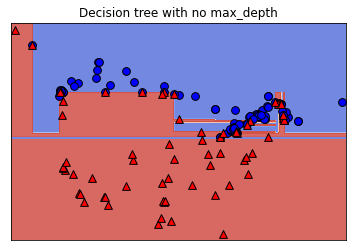

In [56]:
model.fit(X_train, y_train);
plot_classifier(X_train, y_train, model);
plt.title("Decision tree with no max_depth");

### Underfitting 

- Underfitting is somewhat the opposite of overfitting in the sense that it occurs when the model is not complex enough. 
- Underfitting is when our model is too simple (`DecisionTreeClassifier` with max_depth=1). 
- The model doesn't capture the patterns in the training data and the training score is not that high.
- Both train and validation scores are low and the gap between train and validation scores is low as well.

In [57]:
model = DecisionTreeClassifier(max_depth=1)

scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
print("Train score: " + str(round(scores["train_score"].mean(), 2)))
print("Validation score: " + str(round(scores["test_score"].mean(), 2)))

Train score: 0.83
Validation score: 0.81


Standard question to ask ourselves: 
***Which of these scenarios am I in?***

### How can we figure this out?

- If the training and validation scores are very far apart → more likely **overfitting**.     
    - Try decreasing model complexity.

- If the training and validation scores are very close together → more likely **underfitting**.  
    - Try increasing model complexity.

## The "Fundamental Tradeoff" of Supervised Learning

As model complexity increases:

$\text{Training score}$  ↑ and ($\text{Training score} − \text{Validation score}$) tend to also  ↑


If our model is too simple (underfitting) then we won't really learn any "specific patterns" of the training set. 

**BUT** 

If our model is too complex then we will learn unreliable patterns that get every single training example correct, and there will be a large gap between training error and validation error.

The trade-off is there is tension between these two concepts. 

When we underfit less, we overfit more. 

How do we know how much overfitting is too much and how much is not enough? 

### How to pick a model that would generalize better?

In [58]:
results_dict = {"depth": list(), "mean_train_score": list(), "mean_cv_score": list()}

for depth in range(1,20):
    model = DecisionTreeClassifier(max_depth=depth)
    scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv_score"].append(scores["test_score"].mean())
    results_dict["mean_train_score"].append(scores["train_score"].mean())

results_df = pd.DataFrame(results_dict)
results_df

,depth,mean_train_score,mean_cv_score
0,1,0.834349,0.809926
1,2,0.844989,0.804044
2,3,0.862967,0.804412
3,4,0.906865,0.840074
4,5,0.918848,0.851838
5,6,0.930817,0.815074
6,7,0.954115,0.827941
7,8,0.973400,0.821324
8,9,0.980049,0.821691
9,10,0.994013,0.803309


In [59]:
source = results_df.melt(id_vars=['depth'] , 
                              value_vars=['mean_train_score', 'mean_cv_score'], 
                              var_name='score_type', value_name='accuracy')
chart1 = alt.Chart(source).mark_line().encode(
    alt.X('depth:Q', axis=alt.Axis(title="Tree Depth")),
    alt.Y('accuracy:Q'),
    alt.Color('score_type:N', scale=alt.Scale(domain=['mean_train_score', 'mean_cv_score'],
                                           range=['teal', 'gold'])))
chart1

alt.Chart(...)

- As we increase our depth (increase our complexity) our training data increases. 
- As we increase our depth, we overfit more, and the gap between the train score and validation score also increases... except  ... 

- There is a spot where the gap between the validation score and test score is the smallest while still producing a decent validation score.
- In the plot, this would be around `max_depth` is 5. 
- Commonly, we look at the cross-validation score and pick the hyperparameter with the highest cross-validation score. 

In [60]:
results_df.sort_values('mean_cv_score', ascending=False)

,depth,mean_train_score,mean_cv_score
4,5,0.918848,0.851838
3,4,0.906865,0.840074
6,7,0.954115,0.827941
8,9,0.980049,0.821691
7,8,0.973400,0.821324
10,11,0.998004,0.815074
17,18,1.000000,0.815074
5,6,0.930817,0.815074
0,1,0.834349,0.809926
16,17,1.000000,0.809191


Now that we know the best value to use for `max_depth`, we can build a new classifier setting `max_depth=5`, train it and now (only now) do we score our model on the test set.

In [61]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train);
print("Score on test set: " + str(round(model.score(X_test, y_test), 2)))

Score on test set: 0.83


- Is the test error comparable with the cross-validation error?
- Do we feel confident that this model would give a similar performance when deployed? 

## The Golden Rule 

- Even though we care the most about test error **THE TEST DATA CANNOT INFLUENCE THE TRAINING PHASE IN ANY WAY**. 
- We have to be very careful not to violate it while developing our ML pipeline. 
- Why? When this happens, the test data influences our training and the test data is no longer unseen data and so the test score will be too optimistic.
- Even experts end up breaking it sometimes which leads to misleading results and lack of generalization on the real data. 
    - https://www.theregister.com/2019/07/03/nature_study_earthquakes/
    - https://www.technologyreview.com/2015/06/04/72951/why-and-how-baidu-cheated-an-artificial-intelligence-test/
    
How do we avoid this? 

The most important thing is when splitting the data, we lock away the test set and keep it separate from the training data.

Forget it exists temporarily - kinda like forgetting where you put your passport until you need to travel. 

The workflow we generally follow is:

- **Splitting**: Before doing anything, split the data `X` and `y` into `X_train`, `X_test`, `y_train`, `y_test` or `train_df` and `test_df` using `train_test_split`.  
- **Select the best model using cross-validation**: Use `cross_validate` with `return_train_score = True` so that we can get access to training scores in each fold. (If we want to plot train vs validation error plots, for instance.) 
- **Scoring on test data**: Finally, score on the test data with the chosen hyperparameters to examine the generalization performance.

## Let's Practice

**Overfitting or Underfitting**:     

1\. If our train accuracy is much higher than our test accuracy.     
2\. If our train accuracy and our test accuracy are both low and relatively similar in value.     
3\. If our model is using a Decision Tree Classifier for a classification problem with no limit on `max_depth`.    
 
**True or False**:  

4\. In supervised learning, the training score is always higher than the validation score.     
5\. The fundamental tradeoff of ML states that as training score goes up, validation score goes down.      
6\. More "complicated" models are more likely to overfit than "simple" ones.      
7\. If our training score is extremely high, that means we're overfitting.      

```{admonition} Solutions!
:class: dropdown
1. Overfitting
2. Underfitting
3. Likely overfitting
4. False
5. False
6. True
7. False
```

## Let's Practice - Coding 

Below is some starter code that creates your feature table and target column from the data from the `bball.csv` dataset (in the data folder).

In [62]:
bball_df = pd.read_csv('data/bball.csv')
bball_df = bball_df[(bball_df['position'] =='G') | (bball_df['position'] =='F')]

# Define X and y
X = bball_df.loc[:, ['height', 'weight', 'salary']]
y = bball_df['position']

1. Split the dataset into 4 objects: `X_train`, `X_test`, `y_train`, `y_test`. Make the test set 0.2 (or the train set 0.8) and make sure to use `random_state=7`.
2. Build a decision tree model with `max_depth=5`. 
3. Cross-validate using cross_validate() on the objects X_train and y_train specifying the model and making sure to use 10 fold cross-validation and `return_train_score=True`.
4. Convert the scores into a dataframe and save it in an object named scores_df.
5. Calculate the mean value of each column and save this in an object named mean_scores.
6. Is your model overfitting or underfitting? 

## What We've Learned Today<a id="9"></a>

- The concept of generalization.
- How to split a dataset into train and test sets using `train_test_split` function.
- The difference between train, validation, test, and "deployment" data.
- The difference between training error, validation error, and test error.
- Cross-validation and use `cross_val_score()` and `cross_validate()` to calculate cross-validation error.
- Overfitting, underfitting, and the fundamental tradeoff.
- Golden rule and identify the scenarios when it's violated.